In [39]:
import numpy as np
from qutip import *
from qutip.qip.operations import hadamard_transform
from qutip.qip.circuit import QubitCircuit
import matplotlib.pyplot as plt
from math import gcd
from fractions import Fraction

Основна функція запуску алгоритму Шора.
Виконуємо факторизацію числа 35 (можна будь-яке пробувати, але багато чисел не підходять).

In [40]:
def shor_sample():
    print("=" * 60)
    print("АЛГОРИТМ ШОРА — Факторизація цілого числа")
    print("=" * 60)
    
    N = 35                 # Число, яке потрібно розкласти на множники
    precision_bits = 6     # Кількість точних (вимірювальних) квантових бітів
    coprime = 2            # Вибране число, взаємно просте з N
    
    print(f"\nМета: знайти множники числа {N}")
    print(f"Кількість точних бітів: {precision_bits}")
    print(f"Взаємно просте число: {coprime}\n")
    
    # Запуск алгоритму Шора
    result = shor(N, precision_bits, coprime)
    
    # Вивід результату
    if result is not None:
        print(f"\nУСПІХ! {N} = {result[0]} × {result[1]}")
        print(f"Перевірка: {result[0]} × {result[1]} = {result[0] * result[1]}")
    else:
        print("\nНе вдалося отримати правильні множники. Спробуйте ще раз.")

Алгоритм Шора складається з двох частин:
1. Квантової — пошук періоду повторення.
2. Класичної — обчислення можливих дільників числа N.

In [41]:
def shor(N, precision_bits, coprime):
    print("\n" + "─" * 60)
    print("КРОК 1: Квантова частина — визначення періоду")
    print("─" * 60)
    
    repeat_period = shor_qpu(N, precision_bits, coprime)
    
    print("\n" + "─" * 60)
    print("КРОК 2: Класична частина — обчислення множників")
    print("─" * 60)
    
    factors = shor_logic(N, repeat_period, coprime)
    
    return check_result(N, factors)

Класична частина алгоритму.
Використовує знайдений квантовою частиною період для обчислення
можливих дільників числа N.

In [42]:
def shor_logic(N, repeat_period_candidates, coprime):
    """
    Класична частина алгоритму.
    Використовує знайдений квантовою частиною період для обчислення
    можливих дільників числа N.
    """
    print(f"\nОтримані кандидати на період повторення: {repeat_period_candidates}")
    
    factor_candidates = []
    
    for repeat_period in repeat_period_candidates:
        print(f"\n    Аналіз періоду: {repeat_period}")
        
        # Підготовче обчислення coprime^(r/2)
        ar2 = int(coprime ** (repeat_period // 2))
        print(f"   {coprime}^({repeat_period}//2) = {ar2}")
        
        # Обчислення можливих дільників через НСД
        factor1 = gcd(N, ar2 - 1)
        factor2 = gcd(N, ar2 + 1)
        
        print(f"    Можливі множники: {factor1} і {factor2}")
        factor_candidates.append([factor1, factor2])
    
    return factor_candidates

Перевірка отриманих множників.

In [43]:
def check_result(N, factor_candidates):
    print("\n" + "─" * 60)
    print("ПЕРЕВІРКА РЕЗУЛЬТАТІВ")
    print("─" * 60)
    
    for factors in factor_candidates:
        print(f"    Перевірка: {factors[0]} × {factors[1]} = {factors[0] * factors[1]}")
        
        if factors[0] * factors[1] == N:
            if factors[0] != 1 and factors[1] != 1:
                print("    Результат підтверджено.")
                return factors
            else:
                print("    Тривіальний множник (містить 1).")
        else:
            print(f"    Не дорівнює {N}.")
    
    return None


Квантова частина алгоритму Шора.
    
Основні етапи:
1. Підготовка квантових регістрів.
2. Створення суперпозиції за допомогою перетворення Адамара.
3. Модульне експонування (спрощена симуляція).
4. Квантове перетворення Фур’є.
5. Вимірювання та оцінка періоду на основі результату.

In [44]:
def shor_qpu(N, precision_bits, coprime):
    print(f"\nПочаток квантового моделювання...")
    
    # Кількість бітів для представлення N
    N_bits = 1
    while (1 << N_bits) < N:
        N_bits += 1
    
    print(f"    Необхідно {N_bits} біт(и) для представлення числа {N}")
    print(f"    Кількість точних бітів: {precision_bits}")
    
    total_bits = N_bits + precision_bits
    print(f"    Загальна кількість qubit-ів: {total_bits}")
    
    # Підготовка квантового стану |0...0⟩
    state = tensor([basis(2, 0) for _ in range(total_bits)])
    
    # Створення схеми алгоритму
    circuit = build_shor_circuit(N_bits, precision_bits)
    print(f"\n    Створено схему з {circuit.N} кубітів і {len(circuit.gates)} квантових операцій")
    
    print(f"\n    Крок 1: Ініціалізація робочого регістру значенням 1...")
    
    # Накладання перетворення Адамара на точні біти
    print(f"    Крок 2: Формування суперпозиції (оператори Адамара)...")
    print(f"    Точні біти тепер представляють всі значення від 0 до {(1<<precision_bits)-1}")
    
    for i in range(precision_bits):
        H_gate = hadamard_transform()
        ops = [qeye(2) for _ in range(total_bits)]
        ops[N_bits + i] = H_gate
        full_op = tensor(ops)
        state = full_op * state
    
    print(f"\n    Крок 3: Виконання умовних операцій (модульне експонування)...")
    
    for iter in range(precision_bits):
        num_shifts = 1 << iter
        num_shifts = num_shifts % N_bits
        print(f"        Ітерація {iter}: кількість умовних зсувів = {num_shifts}")
    
    print(f"\n    Крок 4: Квантове перетворення Фур’є (QFT)...")
    
    state = qft(state, precision_bits, N_bits)
    
    print(f"\n    Крок 5: Вимірювання квантового стану...")
    
    probs = np.abs(state.full()) ** 2
    measured_value = np.random.choice(len(probs), p=probs.flatten())
    
    read_result = (measured_value >> N_bits) & ((1 << precision_bits) - 1)
    
    print(f"    Отримане виміряне значення: {read_result}")
    
    print(f"\n    Крок 6: Оцінка періоду за виміряним значенням...")
    repeat_period_candidates = estimate_num_spikes(read_result, 1 << precision_bits)
    
    return repeat_period_candidates

Квантове перетворення Фур’є (QFT).
У спрощеній симуляції містить операції Адамара та фазові обертання.

In [45]:
def qft(state, precision_bits, offset):
    for i in range(precision_bits):
        H_gate = hadamard_transform()
        ops = [qeye(2) for _ in range(state.shape[0].bit_length() - 1)]
        ops[offset + i] = H_gate
        full_op = tensor(ops)
        state = full_op * state
        
        for j in range(i + 1, precision_bits):
            angle = 2 * np.pi / (2 ** (j - i + 1))
            # Спрощена симуляція контрольованої фазової операції
    
    return state

Оцінювання періоду за допомогою методу неперервних дробів.
Виміряне значення не є самим періодом — його потрібно апроксимувати.

In [46]:
def estimate_num_spikes(spike, range_val):
    print(f"\n    Перетворення виміряного значення у наближення періоду...")
    
    if spike < range_val / 2:
        spike = range_val - spike
    
    actual = spike / range_val
    print(f"    Виміряне відношення: {spike}/{range_val} ≈ {actual:.4f}")
    
    candidates = []
    best_error = 1.0
    e0, e1, e2 = 0, 0, 0
    
    for denom in range(1, spike):
        numerator = round(denom * actual)
        estimated = numerator / denom
        error = abs(estimated - actual)
        
        e0, e1, e2 = e1, e2, error
        
        if e1 <= best_error and e1 < e0 and e1 < e2:
            repeat_period = denom - 1
            if repeat_period > 0:
                candidates.append(repeat_period)
                best_error = e1
                print(f"    Знайдено можливий період: {repeat_period}")
    
    if not candidates:
        candidates = [2, 4, 6, 12]
        print(f"    Не вдалося визначити період точно. Використано типові значення: {candidates}")
    
    return candidates

Побудова графічного представлення квантової схеми алгоритму Шора.

In [47]:
def build_shor_circuit(N_bits, precision_bits):
    total_bits = N_bits + precision_bits
    qc = QubitCircuit(total_bits, num_cbits=precision_bits)
    
    for i in range(N_bits):
        qc.user_gates = {"WORK": f"Work q{i}"}
    
    qc.add_gate("X", targets=[N_bits - 1])
    
    for i in range(precision_bits):
        qc.add_gate("SNOT", targets=[N_bits + i])
    
    for iter in range(min(precision_bits, 3)):
        control_qubit = N_bits + iter
        for target in range(N_bits):
            if iter < 2:
                qc.add_gate("CNOT", controls=[control_qubit], targets=[target])
    
    for i in range(precision_bits):
        qc.add_gate("SNOT", targets=[N_bits + i])
        for j in range(i + 1, min(i + 2, precision_bits)):
            qc.add_gate("CPHASE", controls=[N_bits + j], targets=[N_bits + i], arg_value=np.pi/4)
    
    for i in range(precision_bits):
        qc.add_measurement("M", targets=[N_bits + i], classical_store=i)
    
    return qc

Візуалізація квантової схеми

In [48]:
def draw_and_save_circuit(N_bits, precision_bits):
    print("\nСтворення графічного зображення квантової схеми...")
    
    qc = build_shor_circuit(N_bits, precision_bits)
    qc.draw()

# ЗАПУСК АЛГОРИТМУ

In [49]:
shor_sample()
    
print("\n" + "=" * 60)
print("Створення детальної діаграми квантової схеми...")
print("=" * 60)

АЛГОРИТМ ШОРА — Факторизація цілого числа

Мета: знайти множники числа 35
Кількість точних бітів: 6
Взаємно просте число: 2


────────────────────────────────────────────────────────────
КРОК 1: Квантова частина — визначення періоду
────────────────────────────────────────────────────────────

Початок квантового моделювання...
    Необхідно 6 біт(и) для представлення числа 35
    Кількість точних бітів: 6
    Загальна кількість qubit-ів: 12

    Створено схему з 12 кубітів і 36 квантових операцій

    Крок 1: Ініціалізація робочого регістру значенням 1...
    Крок 2: Формування суперпозиції (оператори Адамара)...
    Точні біти тепер представляють всі значення від 0 до 63

    Крок 3: Виконання умовних операцій (модульне експонування)...
        Ітерація 0: кількість умовних зсувів = 1
        Ітерація 1: кількість умовних зсувів = 2
        Ітерація 2: кількість умовних зсувів = 4
        Ітерація 3: кількість умовних зсувів = 2
        Ітерація 4: кількість умовних зсувів = 4
       


Створення графічного зображення квантової схеми...


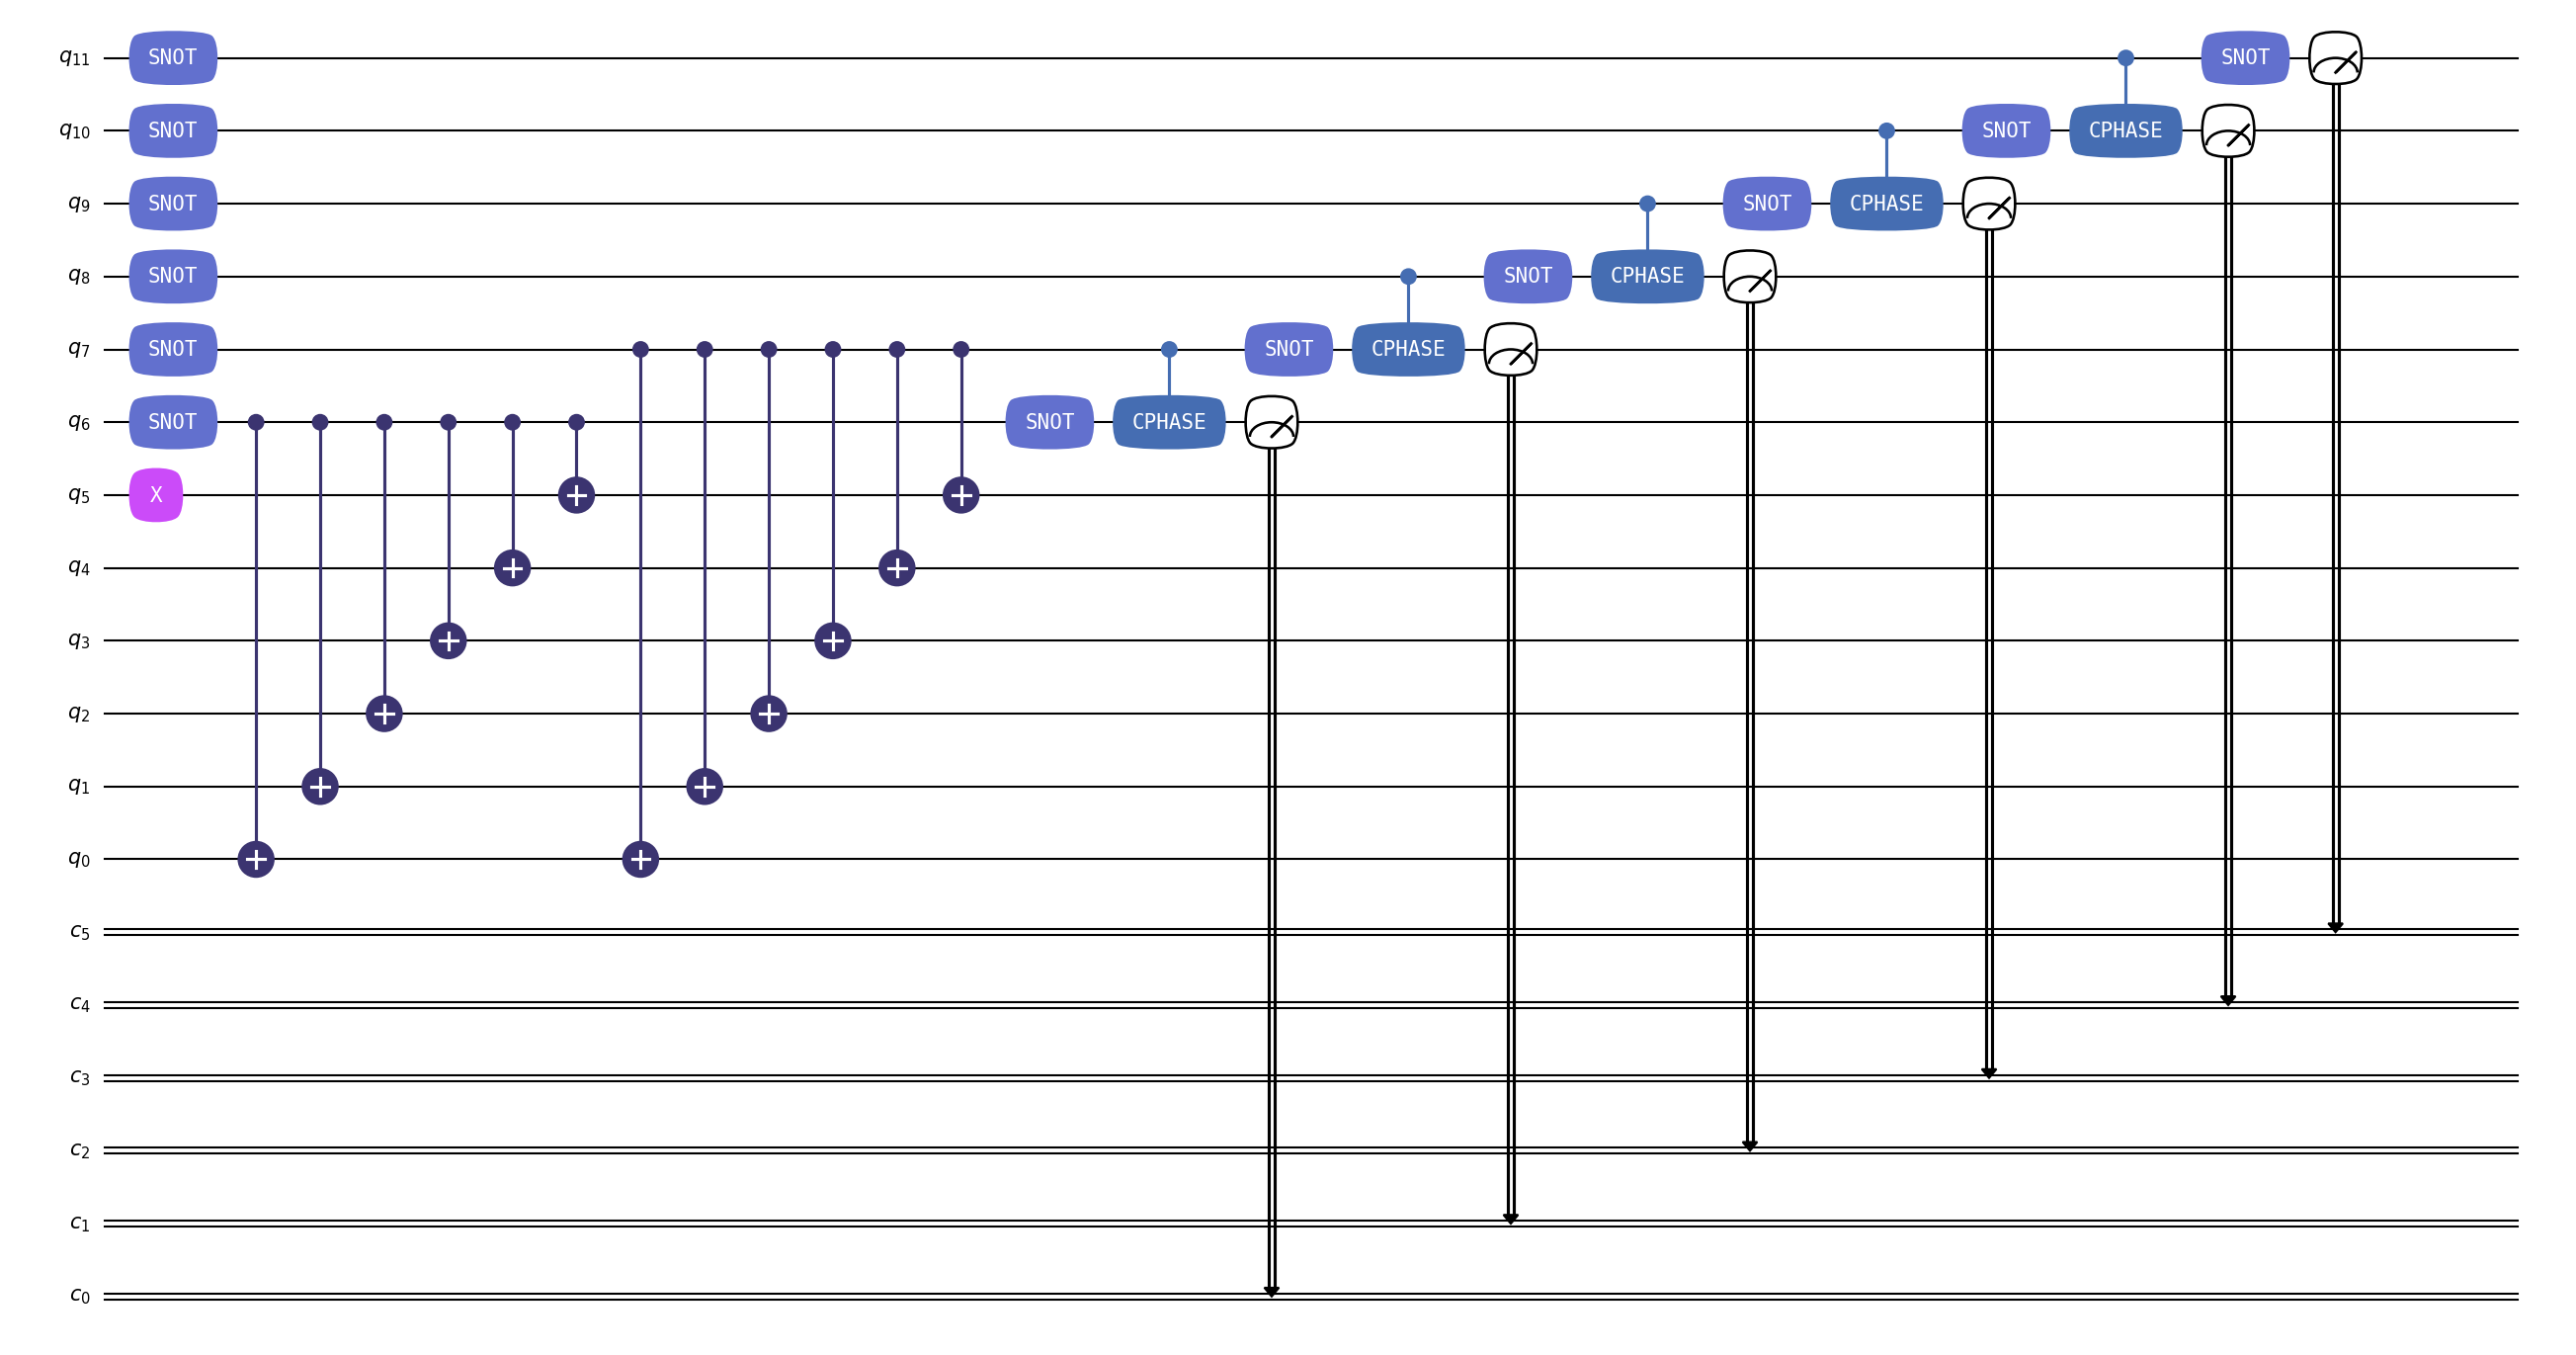

In [50]:
draw_and_save_circuit(N_bits=6, precision_bits=6)